In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
import keras
import sklearn
import math
from sklearn. preprocessing import MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn. preprocessing import MinMaxScaler
from sklearn import linear_model
from keras. models import Sequential
import keras. backend as K
from keras. callbacks import EarlyStopping
from keras. models import load_model
from keras. utils.vis_utils import plot_model

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-05-21 04:14:59.708281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('ADANIPORTS.csv')
print(df.head())

         Date      Symbol Series  Prev Close    Open     High    Low   Last  \
0  2007-11-27  MUNDRAPORT     EQ      440.00  770.00  1050.00  770.0  959.0   
1  2007-11-28  MUNDRAPORT     EQ      962.90  984.00   990.00  874.0  885.0   
2  2007-11-29  MUNDRAPORT     EQ      893.90  909.00   914.75  841.0  887.0   
3  2007-11-30  MUNDRAPORT     EQ      884.20  890.00   958.00  890.0  929.0   
4  2007-12-03  MUNDRAPORT     EQ      921.55  939.75   995.00  922.0  980.0   

    Close    VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  962.90  984.72  27294366  2.687719e+15     NaN             9859619   
1  893.90  941.38   4581338  4.312765e+14     NaN             1453278   
2  884.20  888.09   5124121  4.550658e+14     NaN             1069678   
3  921.55  929.17   4609762  4.283257e+14     NaN             1260913   
4  969.30  965.65   2977470  2.875200e+14     NaN              816123   

   %Deliverble  
0       0.3612  
1       0.3172  
2       0.2088  
3       0.2735  
4

In [3]:
print(df.shape)

(3322, 15)


In [4]:
print(df.isnull().sum())

Date                    0
Symbol                  0
Series                  0
Prev Close              0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
VWAP                    0
Volume                  0
Turnover                0
Trades                866
Deliverable Volume      0
%Deliverble             0
dtype: int64


In [5]:
print(df.columns)

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')


In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Year'] = df['Date'].dt.year
print(df.head())

        Date      Symbol Series  Prev Close    Open     High    Low   Last  \
0 2007-11-27  MUNDRAPORT     EQ      440.00  770.00  1050.00  770.0  959.0   
1 2007-11-28  MUNDRAPORT     EQ      962.90  984.00   990.00  874.0  885.0   
2 2007-11-29  MUNDRAPORT     EQ      893.90  909.00   914.75  841.0  887.0   
3 2007-11-30  MUNDRAPORT     EQ      884.20  890.00   958.00  890.0  929.0   
4 2007-12-03  MUNDRAPORT     EQ      921.55  939.75   995.00  922.0  980.0   

    Close    VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  962.90  984.72  27294366  2.687719e+15     NaN             9859619   
1  893.90  941.38   4581338  4.312765e+14     NaN             1453278   
2  884.20  888.09   5124121  4.550658e+14     NaN             1069678   
3  921.55  929.17   4609762  4.283257e+14     NaN             1260913   
4  969.30  965.65   2977470  2.875200e+14     NaN              816123   

   %Deliverble  Year  
0       0.3612  2007  
1       0.3172  2007  
2       0.2088  2007  


In [7]:
df.index=df['Date']

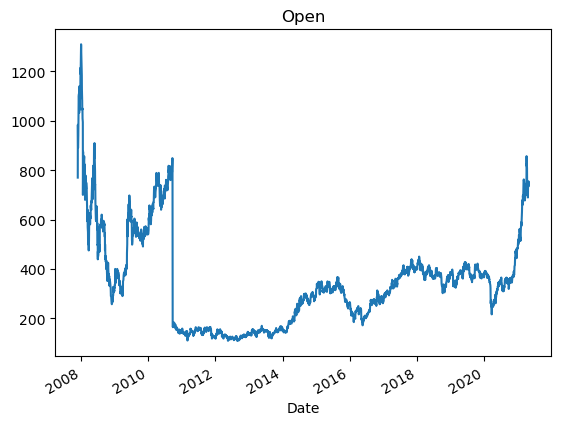

In [8]:
df['Open'].plot()
plt.title("Open")
plt.show()

Text(0.5, 1.0, 'Close')

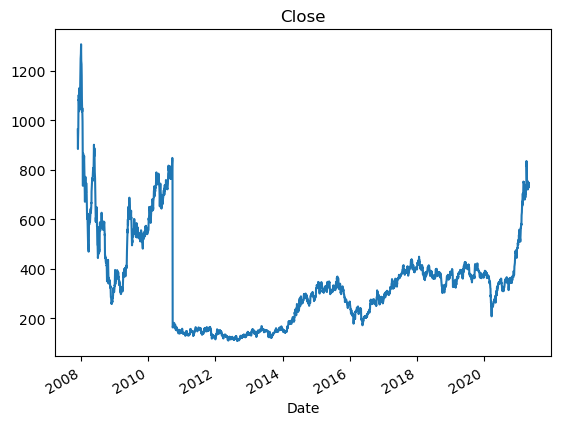

In [9]:
df['Close'].plot()
plt.title("Close")

The size of the train data and test data
(2492, 1)
(830, 1)


/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_77201/1191750749.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_set.loc[:, 'Predictions'] = predictions


The mean square error is :
130.06160038155778


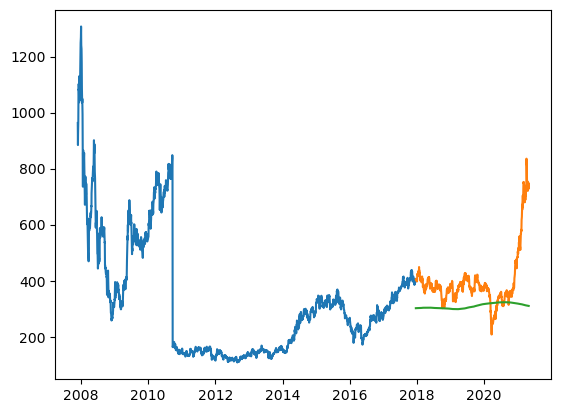

In [10]:
#Model 1
#Predicting the close value using the moving average...
def movingaverage(df):
    shape=df.shape[0]#Number of rows in dataset..
    predictions=[]
    #Dividing the dataset in train and test.
    df_new=df[['Close']]
    train_set=df_new[:math.ceil(shape*0.75)]
    valid_set=df_new[math.ceil(shape*0.75):]
    #Printing the shape of traning set and valid set..
    print("The size of the train data and test data")
    print(train_set.shape)
    print(valid_set.shape)
    for i in range(0,valid_set.shape[0]):
        #Lets average
        a=train_set[train_set.shape[0]-valid_set.shape[0]+i:].sum()+sum(predictions)
        average=a/valid_set.shape[0]
        predictions.append(average)
    valid_set.loc[:, 'Predictions'] = predictions
    plt.plot(train_set['Close'])
    plt.plot(valid_set['Close'])
    plt.plot(valid_set['Predictions'])
    #Lets calculate the error using Mean Square error
    mean=np.mean(np.power(np.array(valid_set['Close']-valid_set['Predictions']),2))
    rms=np.sqrt(mean)
    print("The mean square error is :")
    print(rms)
movingaverage(df)

In [11]:
#Model 2
#LSTM (Long Short term memory)
#Here from the last 40 closing trends we are finding the closing value.

In [12]:
def LSTM_model_1(df):
    shape=df.shape[0]
    df_new=df[['Close']]
    df_train=df_new[:math.ceil(0.75*shape)]
    df_val=df_new[math.ceil(0.75*shape):]
    print("The size of the train data and test data")
    print(df_train.shape)
    print(df_val.shape)
    dataset=df_new.values
    #Lets scale these values between 0 and 1 so that we can easily compute.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(df_train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train,y_train=np.array(x_train),np.array(y_train)
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=60, verbose=2)
    inputs = df_new[len(df_new) - len(df_val) - 40:].values
    #This converts the inputs from an 1D array to an 2D array.
    inputs = inputs.reshape(-1,1)
    #Transforming it into the range 0 to 1.
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    df_val['Predictions'] = closing_price
    plt.plot(df_train['Close'])
    plt.plot(df_val[['Close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)

The size of the train data and test data
(2492, 1)
(830, 1)


2023-05-21 04:15:15.428072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


41/41 - 3s - loss: 0.0046 - 3s/epoch - 65ms/step
26/26 [==============================] - 1s 6ms/step


/var/folders/f7/pwt8mqn53h7cm0yx8tw9dw6m0000gn/T/ipykernel_77201/3165978387.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['Predictions'] = closing_price


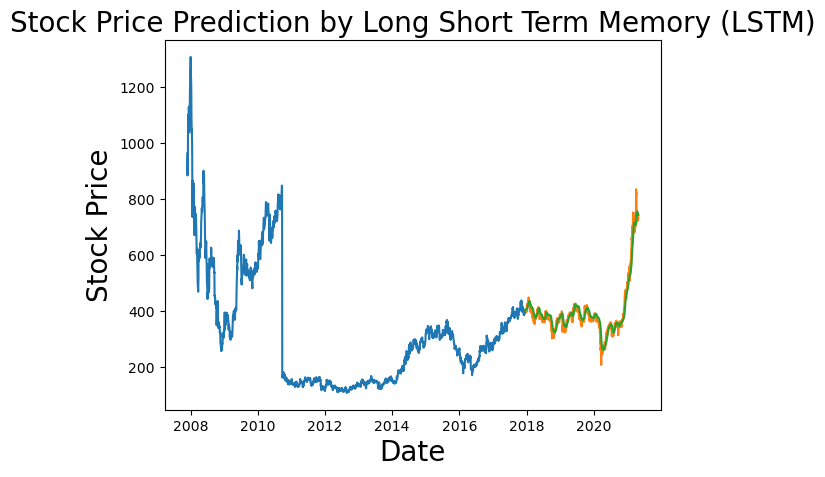

In [13]:
LSTM_model_1(df)

In [14]:
#Model 3
#Using LSTM and Feature Engineering..
print(df.head())

                 Date      Symbol Series  Prev Close    Open     High    Low  \
Date                                                                           
2007-11-27 2007-11-27  MUNDRAPORT     EQ      440.00  770.00  1050.00  770.0   
2007-11-28 2007-11-28  MUNDRAPORT     EQ      962.90  984.00   990.00  874.0   
2007-11-29 2007-11-29  MUNDRAPORT     EQ      893.90  909.00   914.75  841.0   
2007-11-30 2007-11-30  MUNDRAPORT     EQ      884.20  890.00   958.00  890.0   
2007-12-03 2007-12-03  MUNDRAPORT     EQ      921.55  939.75   995.00  922.0   

             Last   Close    VWAP    Volume      Turnover  Trades  \
Date                                                                
2007-11-27  959.0  962.90  984.72  27294366  2.687719e+15     NaN   
2007-11-28  885.0  893.90  941.38   4581338  4.312765e+14     NaN   
2007-11-29  887.0  884.20  888.09   5124121  4.550658e+14     NaN   
2007-11-30  929.0  921.55  929.17   4609762  4.283257e+14     NaN   
2007-12-03  980.0  969.30

In [15]:
#Calculating the EMA 40 -day(Exponential moving average)
multiplier_for_smoothing=2/(40+1)#2/(Number of observations+1)
index=[]
for i in range (len(df)):
    index.append(i)
df['EMA']=df['Close']
df.index=index
df.loc[0, 'EMA'] = df.loc[0, 'Close']
for i in range (1,len(df)):
    df.loc[i, 'EMA'] = df.loc[i, 'Close'] * multiplier_for_smoothing + df.loc[i-1, 'EMA'] * (1 - multiplier_for_smoothing)
df.index=df['Date']
print(df['EMA'])

Date
2007-11-27    962.900000
2007-11-28    959.534146
2007-11-29    955.859310
2007-11-30    954.185685
2007-12-03    954.922969
                 ...    
2021-04-26    713.413429
2021-04-27    715.156677
2021-04-28    716.673424
2021-04-29    718.140574
2021-04-30    718.721522
Name: EMA, Length: 3322, dtype: float64


Text(0.5, 1.0, 'Exponential moving average and Close Price')

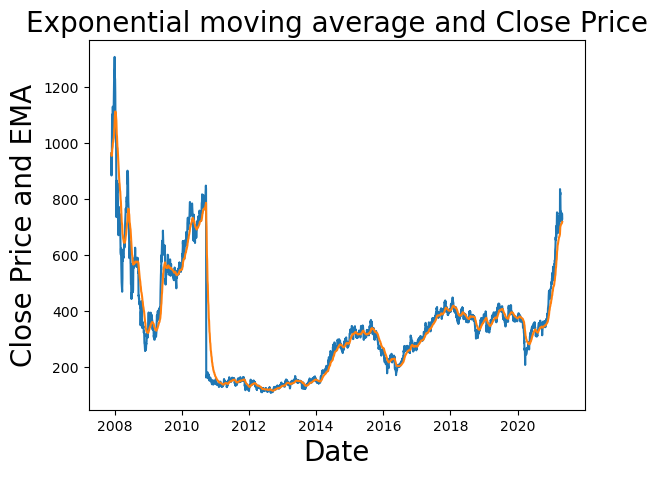

In [16]:
plt.plot(df['Close'])
plt.plot(df['EMA'])
plt.xlabel('Date',size=20)
plt.ylabel('Close Price and EMA',size=20)
plt.title('Exponential moving average and Close Price',size=20)

In [17]:
#V_MA5 (5days trading volume trend)
df['V_MA5']=df['Volume']
df.index=index
for i in range (5,len(df)):
    df.loc[i,'V_MA5']=df.loc[i,'Volume']+df.loc[i-1,'Volume']+df.loc[i-2,'Volume']+df.loc[i-3,'Volume']+df.loc[i-4,'Volume']
    df.loc[i,'V_MA5']=(df.loc[i,'V_MA5'])/5
df.index=df['Date']
print(df['V_MA5'].head)

<bound method NDFrame.head of Date
2007-11-27    27294366.0
2007-11-28     4581338.0
2007-11-29     5124121.0
2007-11-30     4609762.0
2007-12-03     2977470.0
                 ...    
2021-04-26    19783387.8
2021-04-27    19310961.6
2021-04-28    17279323.6
2021-04-29    14681598.4
2021-04-30    13514695.4
Name: V_MA5, Length: 3322, dtype: float64>


Text(0.5, 1.0, '5 days trading volume average')

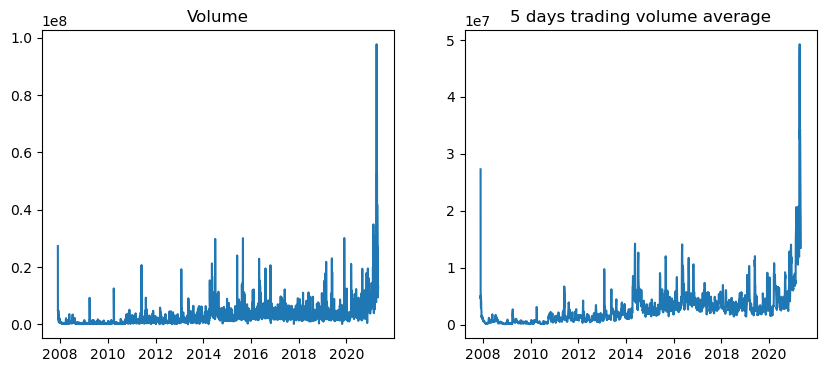

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].plot(df['Volume'])
axs[0].set_title('Volume')
axs[1].plot(df['V_MA5'])
axs[1].set_title('5 days trading volume average')

In [19]:
#SMI- Stochastic Momentum Index.This parameter defines the trends in the stock price.
#This shows where the close price is relative to the mid point of the range.
#The output of SMI varies between -100 and +100. In order to interpret the outcome of SMI, traders have developed
#specific trade points. Like, when SMI rises above the value of +40, 
#a sell signal is indicated. Similarly, if SMI falls below -40, a Purchase signal is indicated.
#Another common trading sign is that, when SMI passes moving average from below, a purchase signal is generated. 
#Similarly, when SMI falls below Moving Average, a sell signal is generated.

Text(0.5, 1.0, 'SMI')

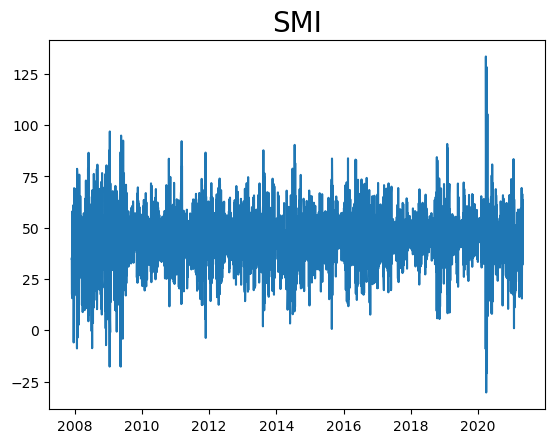

In [20]:
length=10
df['SMI']=0
C=[]
High_Low=[]

for i in range (len(df)-length-1):
    maximum=0
    minimum=0
    for j in range (length):
        maximum=max(maximum,df['High'].iloc[i+j])
        minimum=min(minimum,df['Low'].iloc[i+j])
    C.append((maximum+minimum)/2)
    High_Low.append(maximum-minimum)
for i in range (len(df)-length-1,len(df)):
    j=i
    minimum=0
    maximum=0
    while(j!=len(df)-1):
        maximum=max(maximum,df['High'].iloc[j])
        minimum=min(minimum,df['Low'].iloc[j])
        j+=1
    C.append((minimum+maximum)/2)
    High_Low.append(maximum-minimum)
df.index=index
for i in range (len(df)):
    df.loc[i,'SMI']=df.loc[i,'Close']-C[i]
EMA3_1a=[]
Smoothing_factor=2/3+1
EMA3_1a.append(df.loc[0,'SMI'])
for i in range (len(df)):
    EMA3_1a.append((df.loc[i,'SMI'])*Smoothing_factor+EMA3_1a[i-1]*(1-Smoothing_factor))
EMA3_1b=[]
Smoothing_factor=2/3+1
EMA3_1b.append(EMA3_1a[0])
for i in range (len(df)):
    EMA3_1b.append(EMA3_1a[i]*Smoothing_factor+EMA3_1b[i-1]*(1-Smoothing_factor))
EMA3_2a=[]
EMA3_2a.append(High_Low[0])
for i in range (len(df)):
    EMA3_2a.append(High_Low[i]*Smoothing_factor+EMA3_2a[i-1]*(1-Smoothing_factor))
EMA3_2b=[]
EMA3_2b.append(EMA3_2a[0])
for i in range (len(df)):
    EMA3_2b.append(EMA3_2a[i]*Smoothing_factor+EMA3_2b[i-1]*(1-Smoothing_factor))
for i in range (len(df)):
    df.loc[i,'SMI']=(EMA3_1b[i]*100)/EMA3_2b[i]
df.index=df['Date']
plt.plot(df['SMI'])
plt.title('SMI',size=20)

In [21]:
#MACD Moving Average Convergence Divergence
#MACD is approxiamtely EMA12-EMA26.The shorter EMA is constantly converging towards,
#and diverging away from the longer EMA.

Text(0.5, 1.0, 'Close Price')

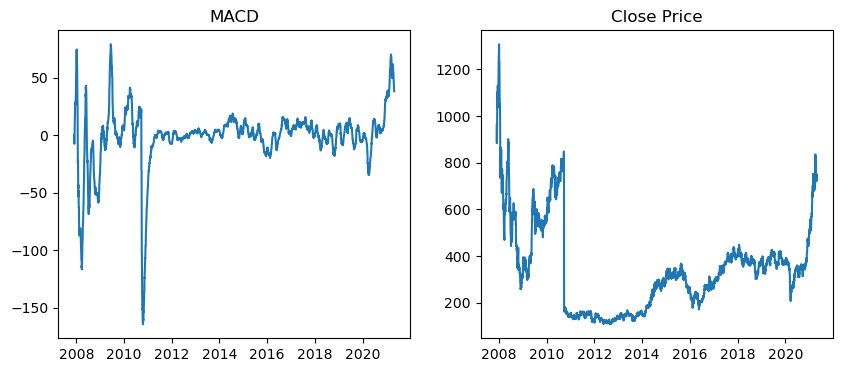

In [22]:
multiplier_for_smoothing=2/(12+1)#2/(Number of observations+1)
EMA12=[]
df.index=index
EMA12.append(df.loc[0,'Close'])
for i in range (len(df)):
    EMA12.append(df.loc[i,'Close']*multiplier_for_smoothing+EMA12[i-1]*(1-multiplier_for_smoothing))
multiplier_for_smoothing=2/(26+1)#2/(Number of observations+1)
EMA26=[]
EMA26.append(df.loc[0,'Close'])
for i in range (len(df)):
    EMA26.append(df.loc[i,'Close']*multiplier_for_smoothing+EMA26[i-1]*(1-multiplier_for_smoothing))
df['MACD']=0
for i in range (len(df)):
    df.loc[i,'MACD']=EMA12[i]-EMA26[i]
df.index=df['Date']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].plot(df['MACD'])
axs[0].set_title('MACD')
axs[1].plot(df['Close'])
axs[1].set_title('Close Price')

Text(0.5, 1.0, 'Close Price')

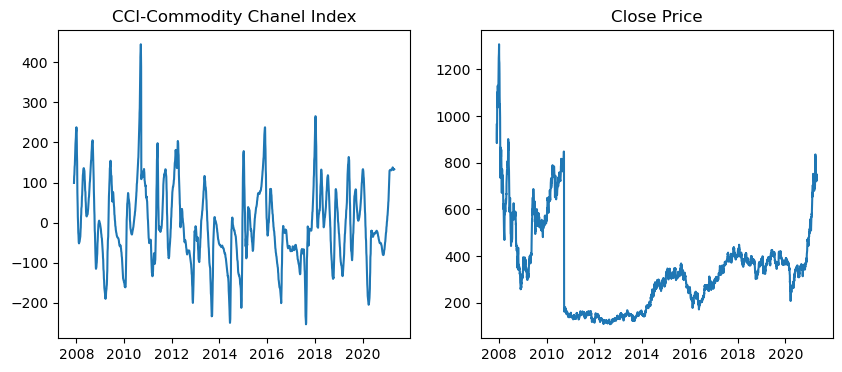

In [23]:
#Calculation of CCI (Commudity Chanel Index)
#CCI=(Typical Price-MA)/(0.015*Mean Deviation)
#It helps to find the start and end of the trend...
period=50
typical_prices=[]
for i in  range (len(df)-49):
    typical_price=0
    for j in range (period):
        typical_price+=((df['High'].iloc[i+j]+df['Low'].iloc[i+j]+df['Close'].iloc[i+j])/3)
    typical_prices.append(typical_price)
for i in range (len(df)-49,len(df)):
    j=i
    typical_price=0
    while(j!=len(df)):
        typical_price+=((df['High'].iloc[j]+df['Low'].iloc[j]+df['Close'].iloc[j])/3)
        j+=1
    typical_prices.append(typical_price)
#Lets calculate the Moving average
MA=[]
for i in range (len(df)-49):
    average=0
    for j in range (period):
        average+=typical_prices[i+j]
    average=average/period
    MA.append(average)
for i in range (len(df)-49,len(df)):
    j=i
    average=0
    while(j!=len(df)):
        average+=typical_prices[j]
        j+=1
    average=average/(j-i+1)
    MA.append(average)
MD=[]
for i in range (len(df)-49):
    deviation=0
    for j in range (period):
        deviation+=abs(typical_prices[i+j]-MA[i+j])
    deviation=deviation/period
    MD.append(deviation)
for i in range (len(df)-49,len(df)):
    deviation=0
    j=i
    while(j!=len(df)):
        deviation+=abs(typical_prices[j]-MA[j])
        j+=1
    deviation=deviation/(j-i+1)
    MD.append(deviation)
df.index=index
df['CCI']=0
for i in range (len(df)):
    df.loc[i,'CCI']=(typical_prices[i]-MA[i])/(0.015*MD[i])   
df.index=df['Date']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].plot(df['CCI'])
axs[0].set_title('CCI-Commodity Chanel Index')
axs[1].plot(df['Close'])
axs[1].set_title('Close Price')

In [24]:
#BOLL Bollinger Bands which provide a relative defination of high and low..
#3 bands are present
#Middle Band = 20-day simple moving average (SMA)
#Upper Band = 20-day SMA + (20-day standard deviation of price x 2) 
#Lower Band = 20-day SMA - (20-day standard deviation of price x 2)

In [25]:
#Middle Band Calculations.
MB=[]
for i in range (len(df)-19):
    average=0
    for j in range (20):
        average+=df['Close'].iloc[i+j]
    average=average/20
    MB.append(average)
i=len(df)-19
average=0
for j in range (19):
    average+=df['Close'].iloc[i+j]
average=average/19
while(len(MB)!=df.shape[0]):
    MB.append(average)
df['MB']=MB

In [26]:
#Calculation of Standard Deviation
SD=[]
for i in range (len(df)-19):
    deviation=0
    for j in range(20):
        deviation+=abs(df['Close'].iloc[i+j]-df['MB'].iloc[i+j])
    deviation=deviation/20
    SD.append(deviation)
for i in range (len(df)-19,len(df)):
    j=i
    deviation=0
    while(j!=len(df)):
        deviation+=abs(df['Close'].iloc[j]-df['MB'].iloc[j])
        j+=1
    deviation=deviation/(j-i+1)
    SD.append(deviation)

In [27]:
#Upper Band Calculations...
df.index=index
df['UB']=0
for i in range (len(df)):
    df.loc[i,'UB']=df.loc[i,'MB']+(SD[i]*2)
df.index=df['Date']

In [28]:
#Lower Band Calculations..
df.index=index
df['LB']=0
for i in range (len(df)):
    df.loc[i,'LB']=df.loc[i,'MB']-(SD[i]*2)
df.index=df['Date']

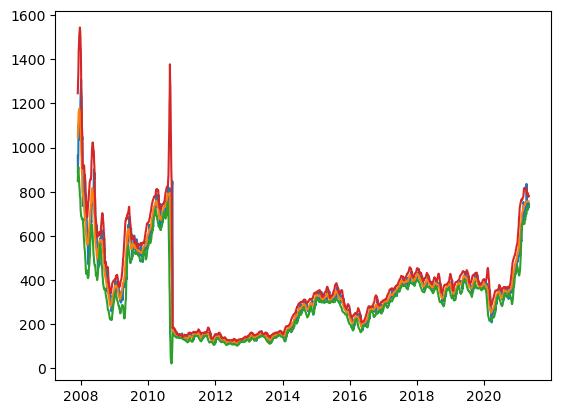

In [29]:
plt.plot(df['Close'])
plt.plot(df['MB'])
plt.plot(df['LB'])
plt.plot(df['UB'])

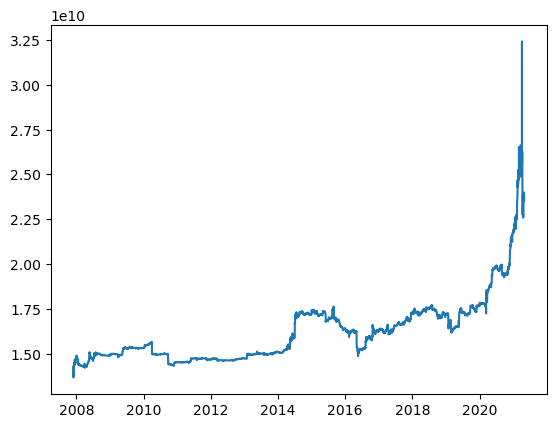

In [30]:
#Calculate Williams Accumulation Distribution...
True_range_high=[]
True_range_low=[]
df.index=index
for i in range(len(df)):
    True_range_high.append(max(df.loc[i,'High'],df.loc[i,'Prev Close']))
for i in range(len(df)):
    True_range_low.append(min(df.loc[i,'Low'],df.loc[i,'Prev Close']))
Price_move=[]
for i in range (len(df)):
    if (df.loc[i,'Close']>df.loc[i,'Prev Close']):
        Price_move.append(df.loc[i,'Close']-True_range_low[i])
    elif (df.loc[i,'Close']<df.loc[i,'Prev Close']):
        Price_move.append(df.loc[i,'Close']-True_range_high[i])
    else:
        Price_move.append(0)
AD=[]
for i in range (len(df)):
    AD.append(Price_move[i]*df.loc[i,'Volume'])
df['Williams_AD']=0
df.loc[0,'Williams_AD']=AD[0]
for i in range (1,len(df)):
    df.loc[i,'Williams_AD']=AD[i]+df.loc[i-1,'Williams_AD']
df.index=df['Date']
plt.plot(df['Williams_AD'])

The size of the train data and val data
(2492, 14)
(830, 14)
Epoch 1/10
78/78 [==============================] - 4s 14ms/step - loss: 0.0097
Epoch 2/10
78/78 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 3/10
78/78 [==============================] - 1s 15ms/step - loss: 0.0017
Epoch 4/10
78/78 [==============================] - 1s 14ms/step - loss: 0.0017
Epoch 5/10
78/78 [==============================] - 1s 14ms/step - loss: 0.0013
Epoch 6/10
78/78 [==============================] - 1s 14ms/step - loss: 0.0011
Epoch 7/10
78/78 [==============================] - 1s 14ms/step - loss: 0.0012
Epoch 8/10
78/78 [==============================] - 1s 14ms/step - loss: 0.0012
Epoch 9/10
78/78 [==============================] - 1s 14ms/step - loss: 0.0011
Epoch 10/10
26/26 [==============================] - 1s 5ms/step


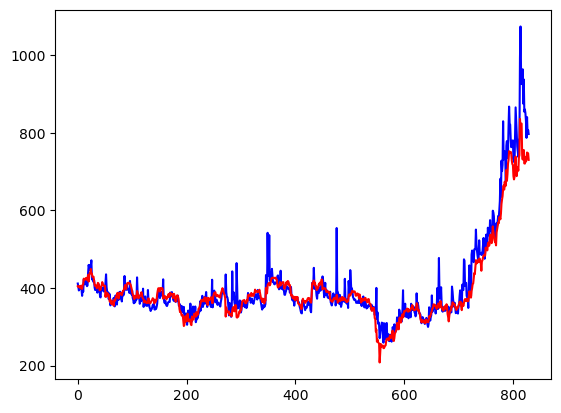

In [31]:
#Lets create the model
def LSTM_model_2(df):
    shape=df.shape[0]
    input_columns=['Open','High','Low','Volume','EMA','V_MA5','SMI','MACD','Volume','CCI','MB','LB','UB','Williams_AD']
    df_input = df.loc[:, input_columns].values
    output_columns=['Close']
    df_output=df.loc[:,output_columns].values
    df_train=df_input[:math.ceil(0.75*shape)]
    df_val=df_input[math.ceil(0.75*shape):]
    df_train_out=df_output[:math.ceil(0.75*shape)]
    df_val_out=df_output[math.ceil(0.75*shape):]
    print("The size of the train data and val data")
    print(df_train.shape)
    print(df_val.shape)
    df_train,df_val,df_train_out,df_val_out=np.array(df_train),np.array(df_val),np.array(df_train_out),np.array(df_val_out)
    scaler1 = MinMaxScaler()
    df_train = scaler1.fit_transform(df_train)
    df_val = scaler1.transform(df_val)
    scaler2=MinMaxScaler()
    df_train_out=scaler2.fit_transform(df_train_out)
    model=Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=(df_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(df_train,df_train_out,epochs=10,batch_size=32)
    predictions=model.predict(df_val)
    predictions=scaler2.inverse_transform(predictions)
    plt.plot(predictions,color='blue')
    plt.plot(df_val_out,color='red')
LSTM_model_2(df)